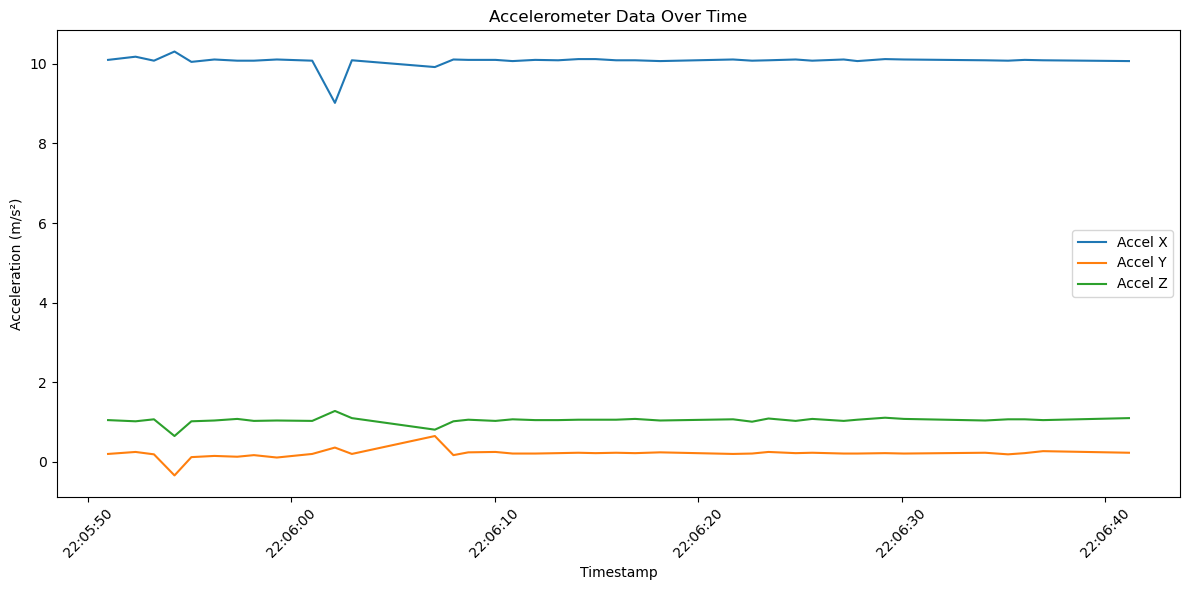

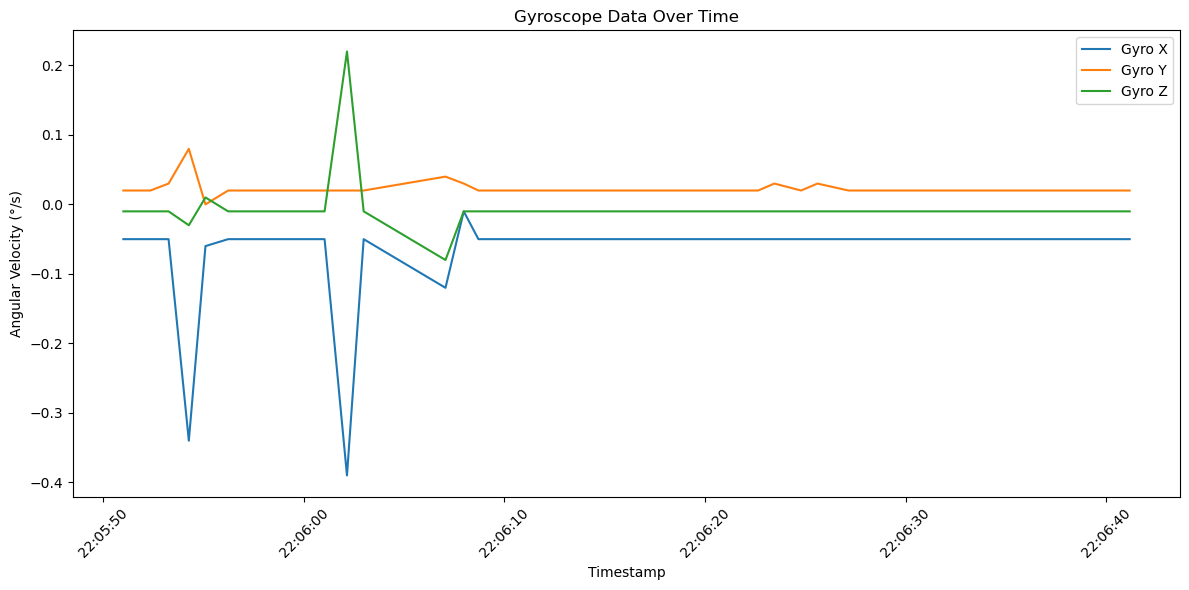

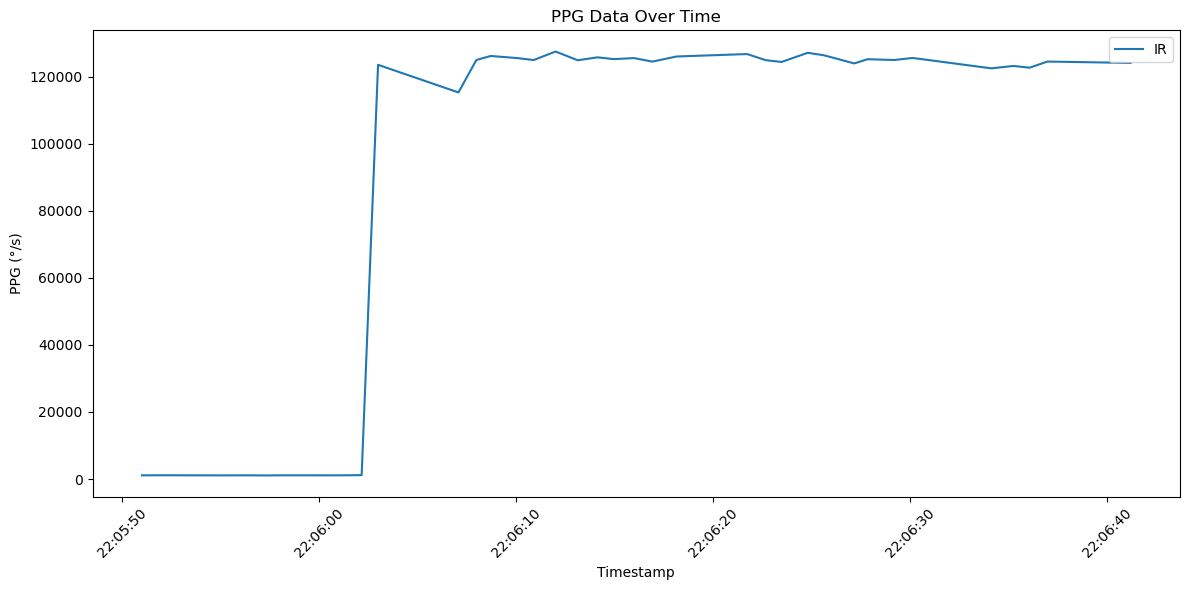

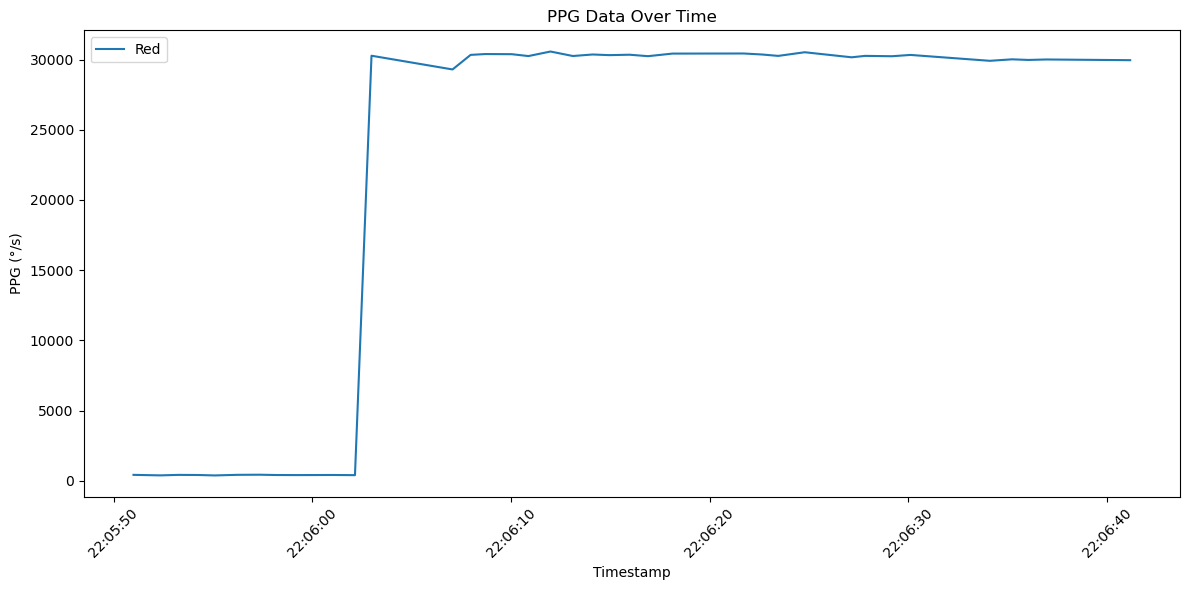

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV data
data = pd.read_csv('aos_data_20250224_220550.csv', parse_dates=['timestamp'])

# Plot accelerometer data
plt.figure(figsize=(12, 6))
plt.plot(data['timestamp'], data['AccelX'], label='Accel X')
plt.plot(data['timestamp'], data['AccelY'], label='Accel Y')
plt.plot(data['timestamp'], data['AccelZ'], label='Accel Z')
plt.xlabel('Timestamp')
plt.ylabel('Acceleration (m/s²)')
plt.title('Accelerometer Data Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot gyroscope data
plt.figure(figsize=(12, 6))
plt.plot(data['timestamp'], data['GyroX'], label='Gyro X')
plt.plot(data['timestamp'], data['GyroY'], label='Gyro Y')
plt.plot(data['timestamp'], data['GyroZ'], label='Gyro Z')
plt.xlabel('Timestamp')
plt.ylabel('Angular Velocity (°/s)')
plt.title('Gyroscope Data Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Plot gyroscope data
plt.figure(figsize=(12, 6))
plt.plot(data['timestamp'], data['IR'], label='IR')
plt.xlabel('Timestamp')
plt.ylabel('PPG (°/s)')
plt.title('PPG Data Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot gyroscope data
plt.figure(figsize=(12, 6))
plt.plot(data['timestamp'], data['Red'], label='Red')
plt.xlabel('Timestamp')
plt.ylabel('PPG (°/s)')
plt.title('PPG Data Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


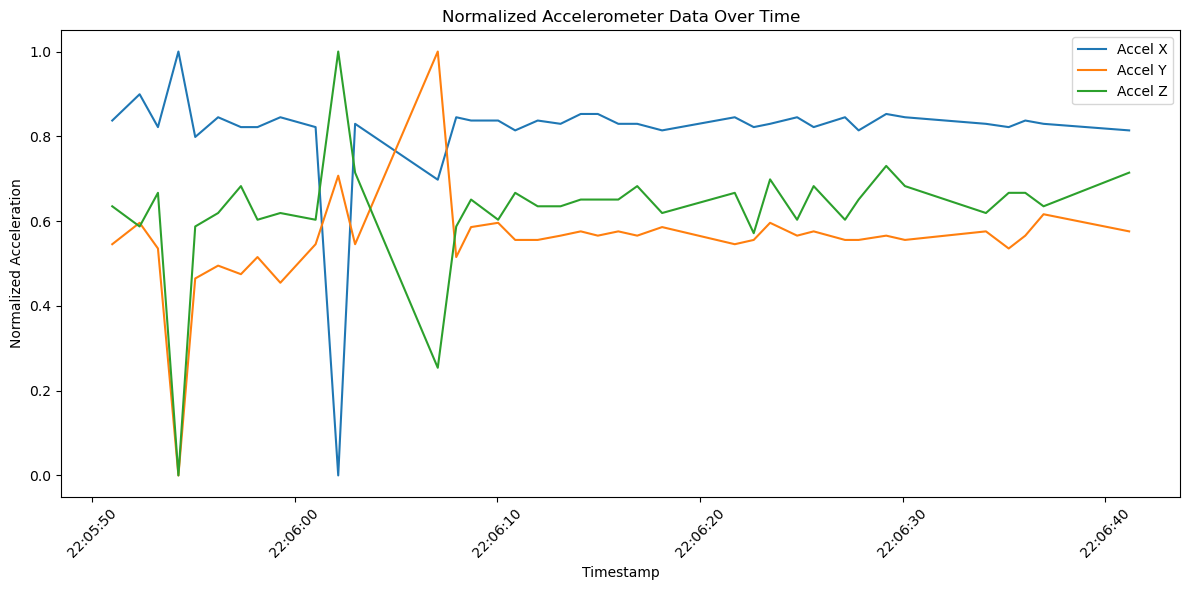

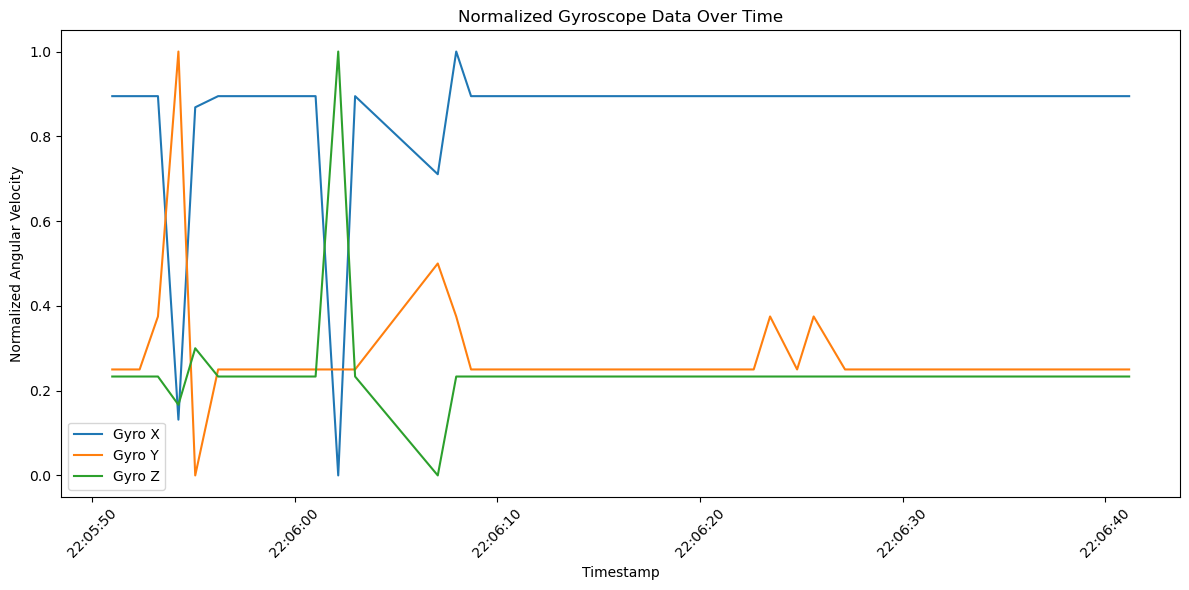

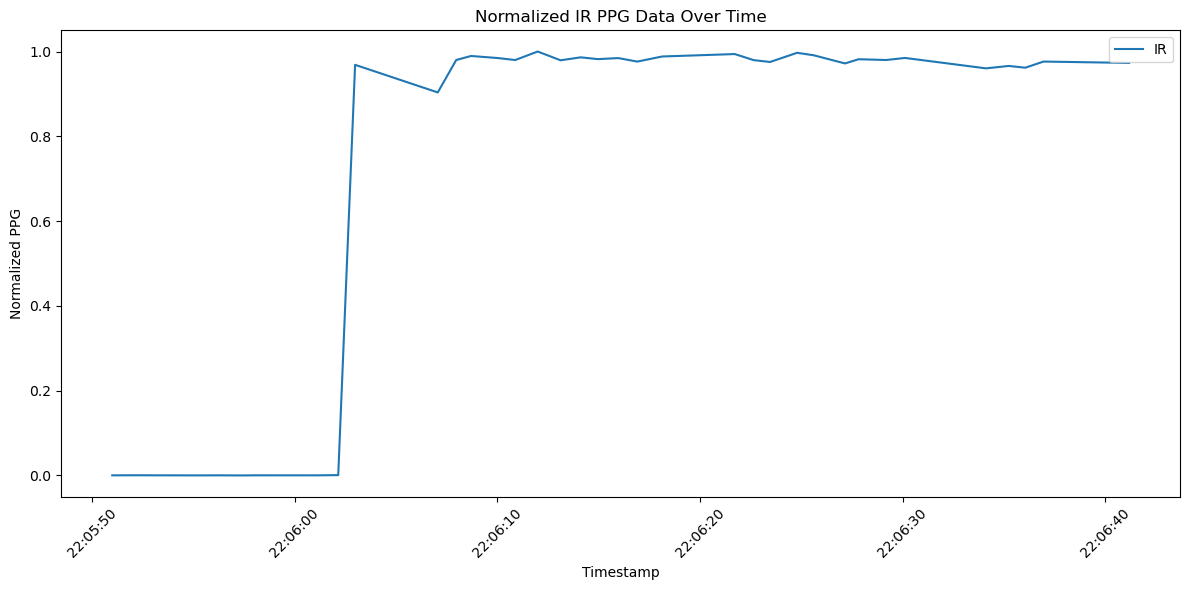

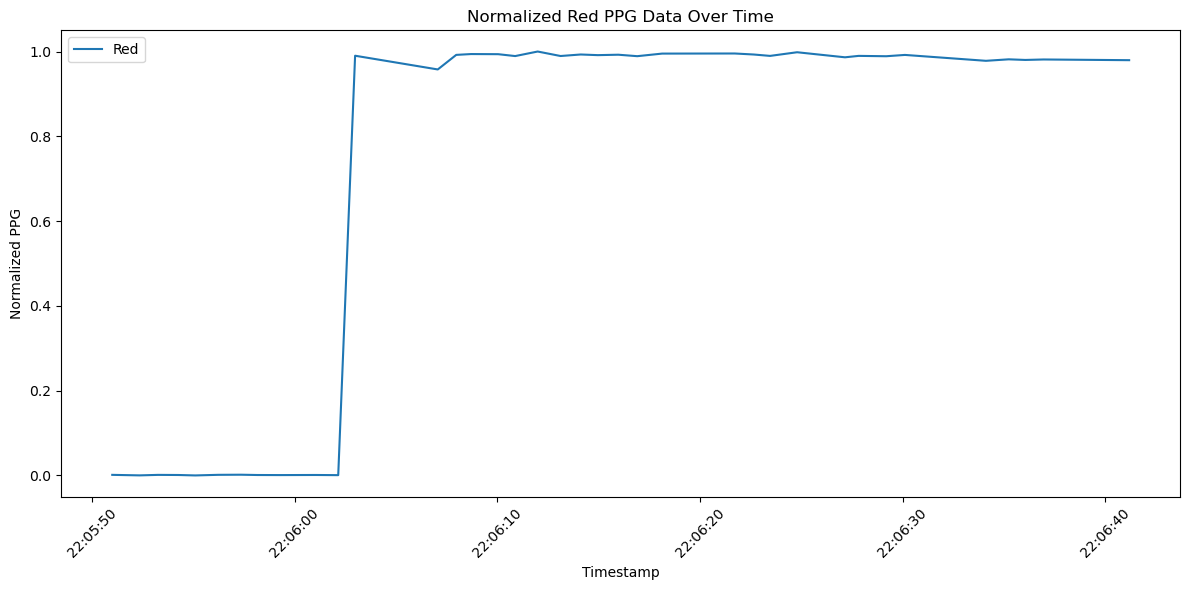

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Load the CSV data
data = pd.read_csv('aos_data_20250224_220550.csv', parse_dates=['timestamp'])

# Normalize the accelerometer, gyroscope, and PPG data
scaler = MinMaxScaler()

# Normalize specific columns
columns_to_normalize = ['AccelX', 'AccelY', 'AccelZ', 'GyroX', 'GyroY', 'GyroZ', 'IR', 'Red']
data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])

# Plot accelerometer data
plt.figure(figsize=(12, 6))
plt.plot(data['timestamp'], data['AccelX'], label='Accel X')
plt.plot(data['timestamp'], data['AccelY'], label='Accel Y')
plt.plot(data['timestamp'], data['AccelZ'], label='Accel Z')
plt.xlabel('Timestamp')
plt.ylabel('Normalized Acceleration')
plt.title('Normalized Accelerometer Data Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot gyroscope data
plt.figure(figsize=(12, 6))
plt.plot(data['timestamp'], data['GyroX'], label='Gyro X')
plt.plot(data['timestamp'], data['GyroY'], label='Gyro Y')
plt.plot(data['timestamp'], data['GyroZ'], label='Gyro Z')
plt.xlabel('Timestamp')
plt.ylabel('Normalized Angular Velocity')
plt.title('Normalized Gyroscope Data Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot IR PPG data
plt.figure(figsize=(12, 6))
plt.plot(data['timestamp'], data['IR'], label='IR')
plt.xlabel('Timestamp')
plt.ylabel('Normalized PPG')
plt.title('Normalized IR PPG Data Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot Red PPG data
plt.figure(figsize=(12, 6))
plt.plot(data['timestamp'], data['Red'], label='Red')
plt.xlabel('Timestamp')
plt.ylabel('Normalized PPG')
plt.title('Normalized Red PPG Data Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
